# `nb12`: Space Shuttle Challenger disaster

The content of this notebook is adapted from "Bayesian Methods for Hackers" (Chapter 2), by Cam Davidson-Pilon.

The Space Shuttle Challenger disaster occurred on January 28, 1986, when the shuttle's rocket boosters exploded after lift-off, killing all seven crew members. An investigation by the presidential commission on the accident found that the explosion was caused by the failure of an O-ring in a field joint on the rocket booster. This failure was due to a faulty design that made the O-ring sensitive to outside temperature and other factors. Of the previous 24 flights, data on O-ring failures was available for 23 flights (one flight's data was lost at sea), but only the data from the 7 flights with damage incidents was considered important. This data did not show any clear trend.

![](figures/nb12/oring.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

<div class="alert alert-success">
    
**Exercise**. Load the data from `"data/challenger.csv"`.
    
</div>

In [2]:
df = pd.read_csv("data/challenger.csv")
df

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [3]:
df = df.dropna()
df = df.iloc[:-1]

In [4]:
data = np.array(df[["Temperature", "Damage Incident"]].values, dtype=int)
temperatures = data[:, 0]
incident = data[:, 1].astype(bool)

<div class="alert alert-success">
    
**Exercise**. Visualize the data.
    
</div>

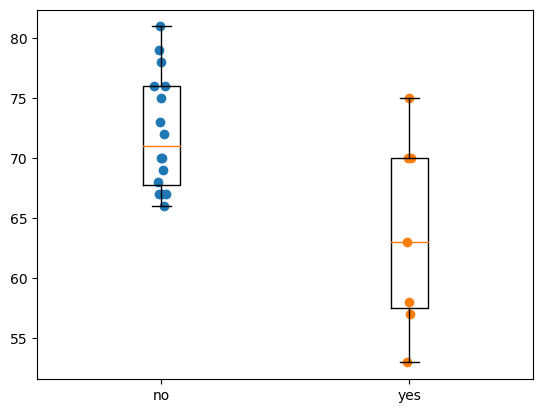

In [5]:
fig = plt.figure()
ax = plt.axes()

ax.boxplot([temperatures[~incident], temperatures[incident]], labels=["no", "yes"])
ax.scatter(np.random.normal(0+1, 0.01, size=len(temperatures[~incident])), temperatures[~incident])
ax.scatter(np.random.normal(1+1, 0.01, size=len(temperatures[incident])), temperatures[incident])

plt.show()

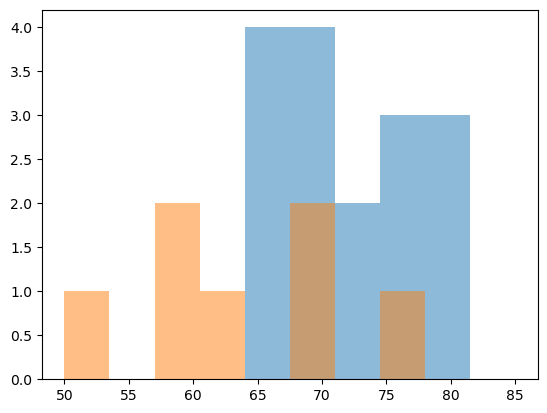

In [6]:
fig = plt.figure()
ax = plt.axes()

ax.hist(temperatures[~incident], bins=10, range=(50, 85), alpha=0.5)
ax.hist(temperatures[incident], bins=10, range=(50, 85), alpha=0.5)

plt.show()

# Probabilistic model

The visual inspection of the data makes it clear that the probability of an incident increases as the outside temperature decreases.

<div class="alert alert-success">
    
**Exercise**. Propose and implement an adequate probabilistic model.
    
</div>

Let us consider a probabilistic model where the failure $F$ is modeled as a Bernoulli random variable with probability parameter $\rho$ following a logistic regression model that is function of the temperature,
$$\rho(t, \alpha, \beta) = \frac{1}{1 + \exp(\beta t + \alpha)},$$
where $t$ is the outside temperature, and $\alpha$ and $\beta$ are hyper-parameters.

In [7]:
def logistic(t, alpha, beta):
    return 1.0 / (1.0 + np.exp(beta * t + alpha)) 

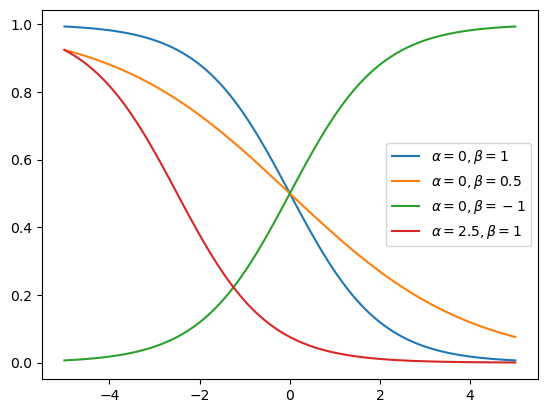

In [8]:
fig = plt.figure()
ax = plt.axes()

ts = np.linspace(-5, 5, 100)
ax.plot(ts, logistic(ts, alpha=0., beta=1.), label=r"$\alpha=0, \beta=1$") 
ax.plot(ts, logistic(ts, alpha=0., beta=0.5), label=r"$\alpha=0, \beta=0.5$") 
ax.plot(ts, logistic(ts, alpha=0., beta=-1.), label=r"$\alpha=0, \beta=-1$") 
ax.plot(ts, logistic(ts, alpha=2.5, beta=1.), label=r"$\alpha=2.5, \beta=1$") 
ax.legend()

plt.show()

For the prior, we first consider weakly informative priors $p(\alpha) = \mathcal{N}(\alpha | 0, 100)$ and $p(\beta) = \mathcal{N}(\beta | 0, 5)$. 

Overall, our probabilistic model is
$$\alpha \sim \mathcal{N}(\alpha | 0, 100)\\
\beta \sim \mathcal{N}(\beta | 0, 5)\\
F_i \sim \text{Bernoulli}\left(\frac{1}{1 + \exp(\beta t_i + \alpha)}\right)$$
for the observations $i=1, \dots, N$.

In [9]:
from scipy.stats import norm

def log_likelihood(theta, f, t):
    return f * np.log(logistic(t, theta[0], theta[1])) + (1-f) * np.log(1 - logistic(t, theta[0], theta[1]))

def log_prior(theta):   
    return (norm.logpdf(theta[0], loc=0., scale=100) + 
            norm.logpdf(theta[1], loc=0., scale=5))

# def log_prior(theta):   
#     return (norm.logpdf(theta[0], loc=0., scale=1) + 
#             norm.logpdf(theta[1], loc=0., scale=1))

def log_posterior(theta, f, t):
    return (log_likelihood(theta, f, t) + log_prior(theta)).sum()

# Inference

<div class="alert alert-success">
    
**Exercise**. Compute the posterior distribution of the model parameters.
    
</div>

In [10]:
import emcee
pos = np.array([0., 0.]) + 0.01 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(incident, temperatures))
sampler.run_mcmc(pos, 25000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:01<00:00, 408.66it/s]


<div class="alert alert-success">
    
**Exercise**. Diagnose the inference results.
    
</div>

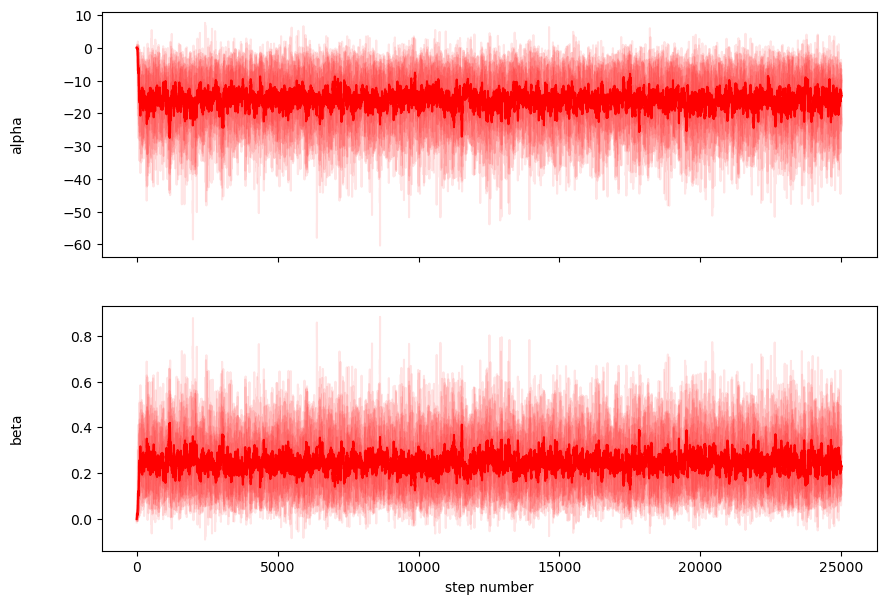

In [11]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "r", alpha=0.1)
    ax.plot(np.mean(samples[:, :, i], axis=1), "r", alpha=1.0)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [12]:
tau = sampler.get_autocorr_time()
tau

array([35.99969696, 36.31634791])

In [13]:
thetas = sampler.get_chain(flat=True, discard=500, thin=40)

<div class="alert alert-success">
    
**Exercise**. Visualize the posterior distribution.
    
</div>

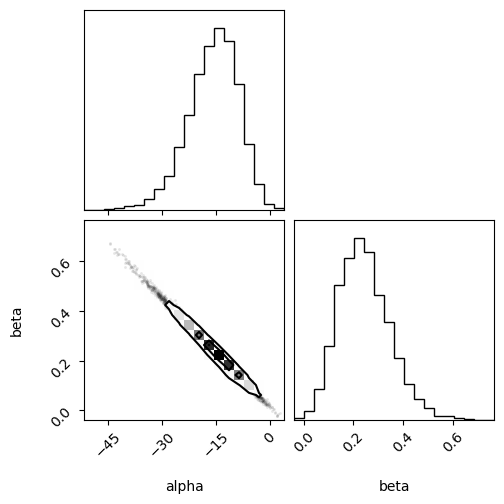

In [14]:
import corner
fig = corner.corner(thetas, labels=labels)

<div class="alert alert-success">
    
**Exercise**. Show the posterior predictive distribution of the probability of an incident.
    
</div>

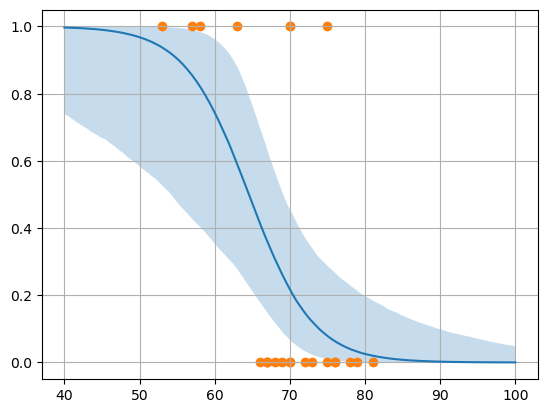

In [15]:
# Posterior predictive
fig = plt.figure()
ax = plt.axes()

ts = np.linspace(40, 100, 100)
preds = np.array([logistic(ts, alpha=theta[0], beta=theta[1]) for theta in thetas])

ax.plot(ts, np.percentile(preds, 50, axis=0)) 
ax.fill_between(ts, 
                np.percentile(preds, 2.5, axis=0), 
                np.percentile(preds, 97.5, axis=0), alpha=0.25)

ax.scatter(temperatures, incident)
ax.grid()

plt.show()

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of the probability of a defect occurring, given this temperature? 

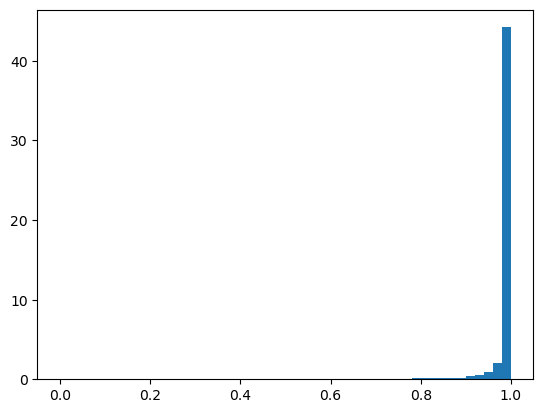

In [16]:
fig = plt.figure()
ax = plt.axes()

preds = np.array([logistic(31, alpha=theta[0], beta=theta[1]) for theta in thetas])
ax.hist(preds, bins=50, range=[0.0, 1.0], density=True)

plt.show()

# Criticism

In [17]:
# Posterior predictive checks
def pp(temperatures, thetas):
    rep = []
    n_samples = len(temperatures)
    
    for theta in thetas:
        rho = logistic(temperatures, theta[0], theta[1])
        u = np.random.rand(*rho.shape)
        rep.append(u < rho)
        
    return rep

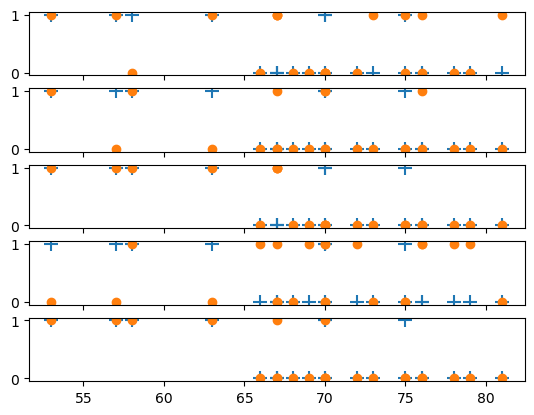

In [18]:
n = 5
fig, ax = plt.subplots(n, sharex=True, sharey=True)

replicas = pp(temperatures, thetas[:n])

for i in range(n):
    ax[i].scatter(temperatures, incident, 100, marker="+")
    ax[i].scatter(temperatures, replicas[i])

plt.show()

In [19]:
replicas = pp(temperatures, thetas)

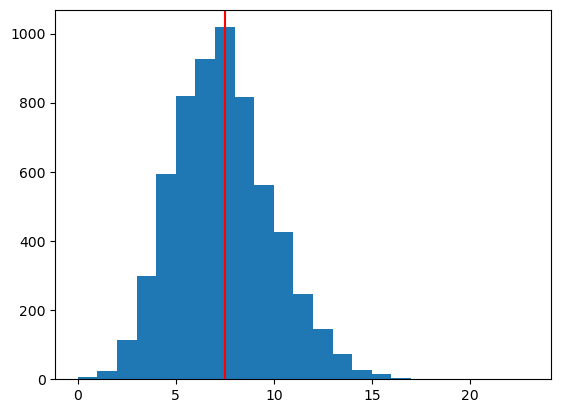

In [20]:
fig = plt.figure()
ax = plt.axes()

ax.hist([np.sum(x_rep) for x_rep in replicas], bins=23, range=(0, 23))
ax.axvline(np.sum(incident)+0.5, color="r")

plt.show()

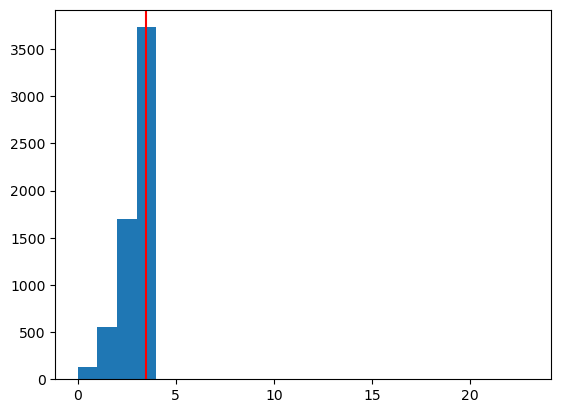

In [21]:
fig = plt.figure()
ax = plt.axes()

ax.hist([np.sum(x_rep[temperatures < 60]) for x_rep in replicas], bins=23, range=(0, 23))
ax.axvline(np.sum(incident[temperatures < 60]) + 0.5, color="r")

plt.show()

## Model comparison

<div class="alert alert-success">
    
**Exercise**. Compare your results using a tighter prior.
    
</div>

In [22]:
# Inference
def log_prior2(theta):   
    return (norm.logpdf(theta[0], loc=0., scale=1) + 
            norm.logpdf(theta[1], loc=0., scale=1))

def log_posterior2(theta, f, t):
    return (log_likelihood(theta, f, t) + log_prior2(theta)).sum()

pos = np.array([0., 0.]) + 0.01 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=(incident, temperatures))
sampler.run_mcmc(pos, 25000, progress=True);

thetas = sampler.get_chain(flat=True, discard=500, thin=40)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:06<00:00, 377.41it/s]


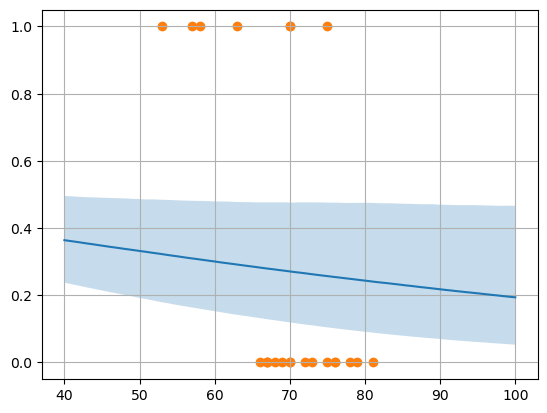

In [23]:
# Posterior predictive
fig = plt.figure()
ax = plt.axes()

ts = np.linspace(40, 100, 100)
preds = np.array([logistic(ts, alpha=theta[0], beta=theta[1]) for theta in thetas])

ax.plot(ts, np.percentile(preds, 50, axis=0)) 
ax.fill_between(ts, 
                np.percentile(preds, 2.5, axis=0), 
                np.percentile(preds, 97.5, axis=0), alpha=0.25)

ax.scatter(temperatures, incident)
ax.grid()

plt.show()

In [24]:
replicas = pp(temperatures, thetas)

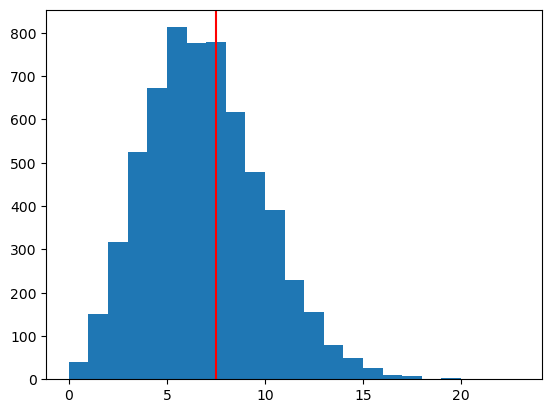

In [25]:
fig = plt.figure()
ax = plt.axes()

ax.hist([np.sum(x_rep) for x_rep in replicas], bins=23, range=(0, 23))
ax.axvline(np.sum(incident)+0.5, color="r")

plt.show()

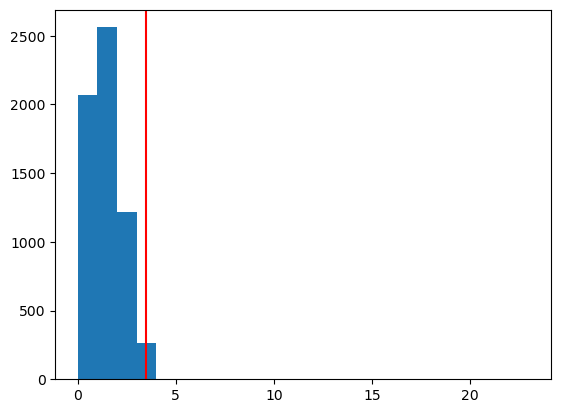

In [26]:
fig = plt.figure()
ax = plt.axes()

ax.hist([np.sum(x_rep[temperatures < 60]) for x_rep in replicas], bins=23, range=(0, 23))
ax.axvline(np.sum(incident[temperatures < 60]) + 0.5, color="r")

plt.show()

<div class="alert alert-success">
    
**Exercise**. Compare your results to random (coin-flip) predictions.
    
</div>

In [27]:
# Same but set b=0.